In [1]:
import os
import logging
import pickle
import datetime

import sys 
sys.path.append("..") 

import numpy as np
import torch

from semi_supervised_AD.models.tgconv_ngat_ae import TGConvNGATAE
from semi_supervised_AD.models.model_helper import init_model
from semi_supervised_AD.data_utils.ntt_dataset import NTTDataset
from semi_supervised_AD.data_utils.data_container import DataContainer
from semi_supervised_AD.utils.train_options import arg_parse, verbose, initialize_tb
from semi_supervised_AD.trainer.tgconv_ngat_trainer import TGConvNGATTrainer
from semi_supervised_AD.trainer.tgconv_ngat_ae_trainer import TGConvNGATAETrainer
from semi_supervised_AD.trainer.tgconv_ngat_cc_trainer import TGConvNGATCCTrainer


In [2]:
device = torch.device(f'cuda:3' if torch.cuda.is_available() else 'cpu')
dataset = NTTDataset(root='/data/yijun/NTT/graph-data/08/1NTT19535_naive_itv_72')
data = DataContainer(dataset, 
                     num_classes=2,
                     batch_size=512,
                     use_unlabel=True,
                     shuffle=True,
                     random_seed=1234)

num_features = data.num_features
num_nodes =  data.num_nodes
    
model = TGConvNGATAE(num_nodes=num_nodes,
                     in_dim=num_features,
                     conv_hidden_channels=64,
                     conv_out_channels=32).to(device)

res_path = '/data/yijun/NTT/model-results-0912/'
model_path = os.path.join(res_path, 'TGConvNGATAE_1NTT19535_naive_itv_72_h32_rs1234', 
                          'models/model.pkl')

model.load_state_dict(torch.load(model_path, map_location=device))


weighted labels: [0.10814627 0.89185373]


<All keys matched successfully>

In [7]:
node_emb, graph_emb, y = [], [], []

model.eval()
with torch.no_grad():

    for loader in [data.train_loader, data.unsup_loader]:
        for i, dat in enumerate(loader):

            dat = dat.to(device)
            emb, rec = model(dat)
            emb = emb.cpu().numpy()
            node_emb.append(emb)
            graph_emb.append(np.sum(emb, axis=2).squeeze())
            y.append(dat.y.cpu().numpy())
        
    y = np.concatenate(y, axis=0)
    node_emb = np.concatenate(node_emb, axis=0)
    graph_emb = np.concatenate(graph_emb, axis=0)


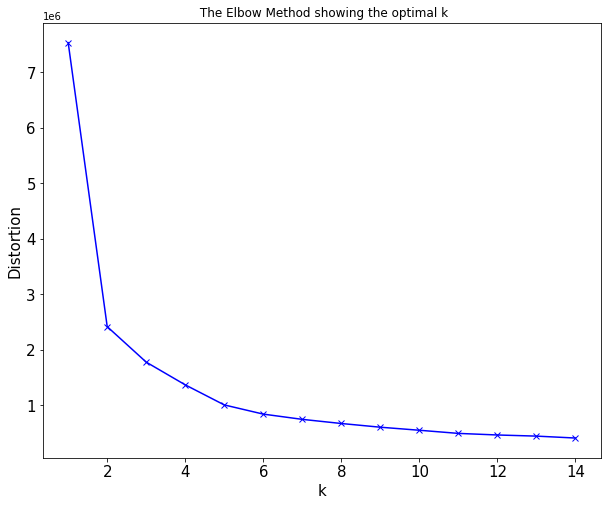

In [14]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

num_samples = graph_emb.shape[0]
graph_emb1 = graph_emb.reshape(num_samples, -1)
graph_emb1, y1 = graph_emb1[y<1], y[y<1]

distortions = []
K = 15
for i in range(1, K):
    
    km = KMeans(n_clusters=i, random_state=0).fit(graph_emb1)
    err = km.inertia_
    distortions.append(err)
    
# Plot the elbow
plt.figure(figsize=(10, 8))
plt.plot(range(1, K), distortions, 'bx-')
plt.xlabel('k', fontsize=15)
plt.ylabel('Distortion', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(' The Elbow Method showing the optimal k')
plt.show()


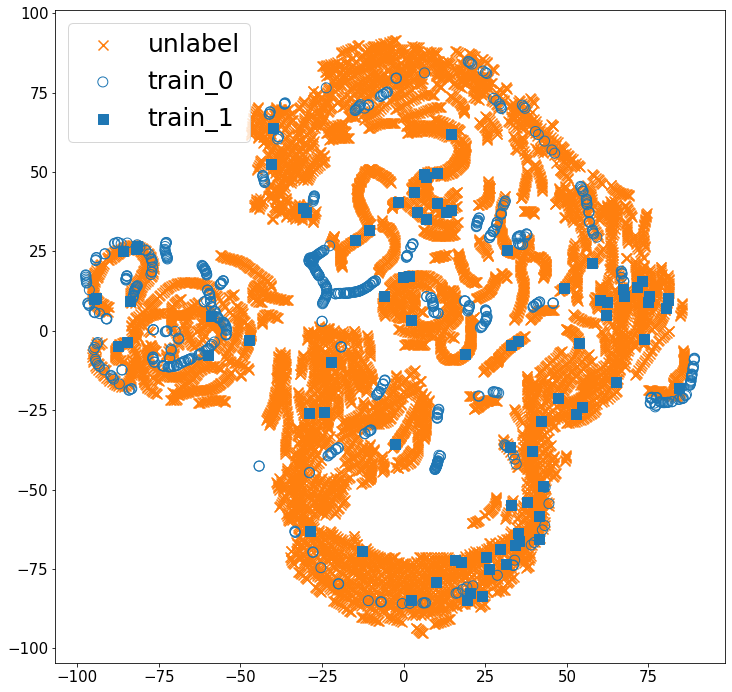

In [10]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

y[y < 0] = 2
x = TSNE(n_components=2, random_state=3333).fit_transform(graph_emb1)
df = pd.DataFrame(columns=['x0', 'x1', 'y'])
df['x0'], df['x1'], df['y'] = x[:, 0], x[:, 1], y

labels = ['train_0', 'train_1', 'unlabel']
colors = sns.color_palette("tab10", 4)
palette = {'train_0': colors[0], 'train_1': colors[0], 'unlabel': colors[1]}
markers = {'train_0': 'o', 'train_1': 's', 'unlabel': 'x'}

def plot(col, name):
    fig = plt.figure(figsize=(12, 12))
    for i in [2, 0, 1]:
        mi, ci = markers[labels[i]], palette[labels[i]]
        x0, x1 = df[df[col] == i]['x0'], df[df[col] == i]['x1']
        if mi == 'o':
            plt.scatter(x0, x1, s=100, facecolor='none', edgecolors=ci, marker=mi, label=labels[i]) #, alpha=0.9)
        else:
            plt.scatter(x0, x1, s=100, color=ci, marker=mi, label=labels[i])
                
    plt.legend(prop={'size': 25})
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()
    plt.close()

plot(col='y', name='label')        


In [48]:
print(len(data.unsup_dataset))

8120
